# A basic ML model to check the freshness of a fruit

## Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Data preprocessing

### Setting Directories

- **"tf.keras.utils.image_dataset_from_directory"** is a library function which loads images from a directory
- we have three directories here, *test, train and validation*, each directory here has four classes
- label_mode defines how the lables are represented by the library function
- seed ensures the random split between training and validation dataset is consistent and no images appear in both subsets if you run your code multiple times. (since we are splitting training set into two parts instead of creating a different directory for validation set)

In [23]:
batch_size = 32 #instead of processing one image at a time, the images are processed in a batch of 32
img_height = 180
img_width = 180
validation_split = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    r"D:\Study stuff\Fruit insights project\model\Model-1-fruit-freshness\train",
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',  
    shuffle=True,
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    r"D:\Study stuff\Fruit insights project\model\Model-1-fruit-freshness\train",
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    r"D:\Study stuff\Fruit insights project\model\Model-1-fruit-freshness\test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',  
    shuffle=False,
)
print("Class Names:",train_ds.class_names)
class_names = train_ds.class_names


Found 8733 files belonging to 4 classes.
Using 6987 files for training.
Found 8733 files belonging to 4 classes.
Using 1746 files for validation.
Found 2570 files belonging to 4 classes.
Class Names: ['freshapples', 'freshoranges', 'rottenapples', 'rottenoranges']


### Normalizing pixel values

- Raw images have pixel values in range 0-255
- The neural networks train faster in a standardized range (0.0 - 1.0). For that we use normalization, it reduces effects of variations in lightning, brightness and contrast in images.
- **normalization_layer** rescales each pixel by multiplying it from (1/255) which converts the range of pixels to a floating point number between 0.0 to 1.0.

---

- here the **map()** applies the lambda function to each batch
- **x** is a batch of images
- **y** is a batch of labels for each image in the batch (categories of images i.e. fresh apples, fresh oranges etc)
- you can imagine labels are [0,1,2,3] where 0 is for fresh apples, 1 is for fresh oranges, 2 is for rotten apples and 3 is for rotten oranges. The labels remain the same.


In [20]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

### Optimizing data set loading

- **tf.data.AUTOTUNE** makes sure the data pipeline has the right number of threads working in parallel so training is smooth and efficient. Here threads are for the number of operations like map(), prefetch() etc. that are present in the data pipeline.
- **data pipeline** includes a number of processes such as, loading them from the disk, resizing them, shuffling them, normalizing them, batch them and feed them to the model.
- **cache()**: Stores the data in RAM after the first epoch (or on disk if RAM is small), this avoids reloading images again in later epochs which results in faster training.
- **shuffle():** is used because it randomizes the order of images so that the machine is not focusing on a specific order during training, tensorflow randomly selects the next image from the buffer.
- **prefetch()**: prepares the next batch of data while the model is being trained on the current one
- **prefetch(buffer_size=AUTOTUNE)**: lets tensorflow automatically choose the optimal number of batches to prepare in advance.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


## CNN model
( Convolutional Neural Network )

- The **layers module** provides building blocks of a neural network. Here each layer performs a specific transformation on data.
Such as - **Conv2D** : detects patterns/features
        - **MaxPooling2D** : shrinks data while keeping important information
        - **Flatten** : Converts Multidimentional data into 1D vector
        - **Dense** : Combines all features to make a decision

- The **models module** provides a container to organize and connect the layers together into a complete neural network

In [6]:
from tensorflow.keras import layers, models

### Model creation

I am using a **Sequential model**, which means the output of one layer is directly passed as input to the next (layers are stacked one after another). The steps are given below. 

#### 1. Input Layer
- The model takes an image of size **180 × 180** with **3 color channels (RGB)**.

#### 2. Convolution + Pooling Layers (Feature Extraction)
- **Conv2D(32, 3×3, ReLU):** Detects very basic features like *edges, corners, and lines*. 
- **ReLU:** ensures we only keep the useful signals by removing negative values
- **MaxPooling(2×2):** Shrinks the image while keeping the strongest signals. This process makes the model faster and avoids overfitting.
- **Dropout(0.25):** Dropout randomly sets 25% of those values to 0. This prevents the model to memorize which helps to focus on learning different patterns.  

- **Conv2D(64, 3×3, ReLU):** Detects more complex features like *textures, curves, and shapes*.  
- **MaxPooling(2×2):** Same function
- **Dropout(0.25):** Same function

- **Conv2D(128, 3×3, ReLU):** Detects high-level, detailed features like *eyes, leaves, or object parts*.  
- **MaxPooling(2×2):** Same function. 
- **Dropout(0.25):** Same function

At this stage, the image has been turned into a set of **2D feature maps** (many small grids that represent different learned patterns).

#### 3. Flatten Layer
- The 2D feature maps are **flattened into a 1D vector**.  
- This means all the detected features are lined up in a row so they can be used for decision making.

#### 4. Dense(128, ReLU)
- This is a **fully connected layer** that learns **combinations of features**.  
- Example: *“If this edge + this texture + this color appear together  :- it might mean ‘fresh fruit’.”*  
- **Dropout(0.50):** In dense layers every neuron is connected to every neuron in next layer so it makes them prone to *overfitting* (memorizing), therefore, dropping 50% of neurons ensures that model focuses on general patterns instead of memorizing.

#### 5. Dense(4, Softmax)
- This layers has 4 neurons (because we have 4 classes). So each neuron corresponds to one class.
- The output comes out as raw values called logits, they can be positive or negative.
- Softmax converts them into probabilities that add up to 1. 
- For example if logits are [-0.35, 0.1, 3.4, 0.01]
- then after softmax it will be [0.8, 0.1, 0.05, 0.05] (sum of them is equal to 1). This means that the machine is 80% confident that the given image belongs to first class.

In conclusion, Convolution + pooling are feature extracters, the dense layers act as decision makers, softmax gives us probabilites for each class.


In [7]:
model = models.Sequential([
    layers.Input(shape=(180, 180, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax')  
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,492 (25.36 MB)

 Trainable params: 6,647,492 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compilation of the model

- Here the neural network gets ready for training
- **optimizer** is like an engine of learning.
- **'adam'** (Adaptive moment estimation) automatically updates the learning rate for each parameter so the model continues to learn from it's mistakes.
- The **loss function** measures how far the model's predictions are from the actual data.
- **Categorical crossentropy** focuses on the correct class and checks how confident the model is about predicting it.
- **metrics** tell us how well the model is performing, accuracy simply means the percentage of correct prediction.

In [8]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training the model

- **EarlyStopping** is used to prevent overfitting. It will watch the validation loss and stops training when there is no improvement.
- **patience = 2** means it will wait for 2 epochs to see if the validation loss improves and if it doesn't then it will stop the training.
- **restore_best_weights=True** makes sure the best version of the model is kept
---
- **epochs** means that the model will go through the entire training dataset 10 times and each time it will try to improve.
---
- **model.fit** trains the neural network, it takes the training dataset in batches and feeds it to the model.
- After each epoch, the model will check its perfomance on validation data to see if it's learning patterns or overfitting(memorizing).
- Normally it will run for 10 epochs. Where first epoch will be 1/10 and last will be 10/10.
- But with early_stop the training may stop before 10 epochs if the validation loss is not improving.
- This training process is saved in "history"
---
The training process is tracked with:
- accuracy → how well it predicts on training data
- loss → error on training data
- val_accuracy → how well it predicts on validation data
- val_loss → error on validation data
---
***Why are we checking validation loss?***
The model sees training data again and again so it might memorize it. Validation data is the unseen data so with that data we check if our model is learning or memorizing. By improvement in validation loss value, we mean the lower it gets the better. When the validation loss starts going up, that's when the earlyStopping kicks in. If the validation loss stops improving it means that the model is memorizing training data and it's not generalizing well.

***Accuracy vs loss***
- Accuracy is a percentage of correctly predicted labels.
- Loss is a numerical score which tells how wrong the predictions are. 
- We are using *categorical crossentrophy* which looks at the predicted probabilities (from softmax). The higher the probability for correct class, smaller the loss. vice versa.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping 

early_stop = EarlyStopping(monitor='val_loss',patience = 2, restore_best_weights=True)

epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,  
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.6119 - loss: 0.9327 - val_accuracy: 0.8116 - val_loss: 0.5688
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.8151 - loss: 0.5080 - val_accuracy: 0.8540 - val_loss: 0.4267
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.8544 - loss: 0.4011 - val_accuracy: 0.8889 - val_loss: 0.3314
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.8809 - loss: 0.3251 - val_accuracy: 0.9003 - val_loss: 0.2700
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.8952 - loss: 0.2884 - val_accuracy: 0.9204 - val_loss: 0.2258
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9209 - loss: 0.2230 - val_accuracy: 0.9170 - val_loss: 0.2202
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9282 - loss: 0.1910 - val_accuracy: 0.9296 - val_loss: 0.1967
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.9333 - loss: 0.1892 - val_accu

### Analysis

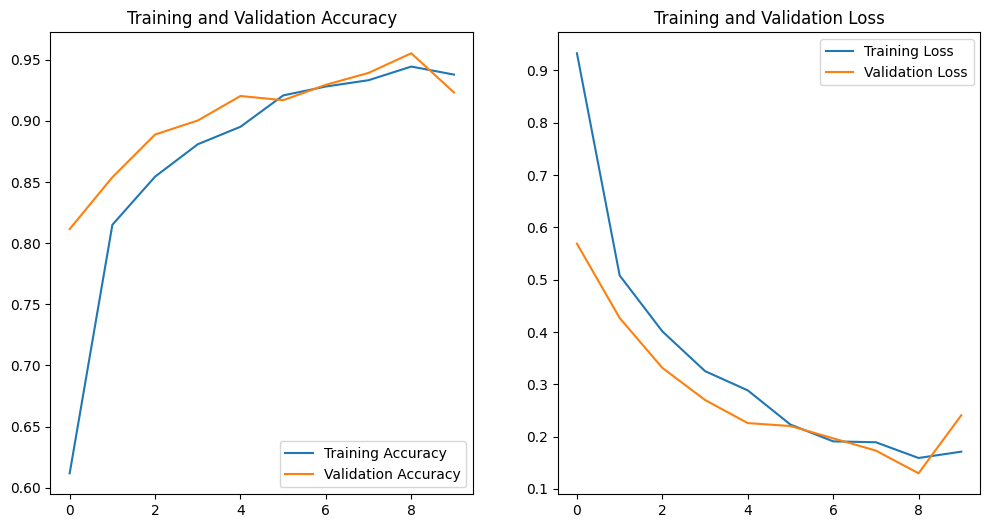

In [29]:
# collecting the data we received from model training for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) # used as x-axis values

plt.figure(figsize=(12, 6)) # figure size , 12 width and 6 height
plt.subplot(1, 2, 1) # 1 row, 2 columns, index (first subplot)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # 1 row, 2 columns, index (second subplot)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


> So from the above plots let's understand what we got.

- **Accuracy Plot**
- Both training and validation accuracy go up over time
-> means the model is learning.

- Training and validation accuracy stay close together
-> means the model is not overfitting.

- Validation accuracy should not suddenly drop
-> if it does, the model is memorizing instead of learning.

- **Loss Plot**
- Both training and validation loss go down
-> good sign, the model is reducing mistakes.

- Training loss much lower than validation loss
-> overfitting.

- Validation loss stops improving while training loss keeps going down
-> overfitting.

- Validation loss should not keep rising
-> if it does, your model is failing to generalize.

### Evaluation

- **model.evaluate(test_ds)** : It runs the model in test dataset using the same metrics we defined during compilation (loss and accuracy). It returns them as a list [loss, accuracy]
- **test_loss** : error score on test dataset
- **test_acc** : percentage of correct predictions on test dataset
- **print(f"Test accuracy: {test_acc:.3f}")** : prints accuracy rounded to 3 decimal places

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 406ms/step - accuracy: 0.9689 - loss: 0.1011
Test accuracy: 0.969


| Accuracy Range | Model Quality |
|----------------|---------------|
| <70% | Poor |
| 70-80% | Fair - Acceptable starting poing |
| 80-90% | Good - Reliable for some tasks |
| 90-95% | Very good - Strong, robust model |
| >95% | Excellent - (check for overfitting)|

### Make predictions

> Predicting by providing a path of an image
- **img_path** stores the path (obviously)
- **tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))** : loads an image and resizes it to model's expected size (180 by 180)
- **tf.keras.utils.img_to_array(img)** : Image is converted into a 3D array (height, width, channels) eg-  (180,180,3) for an RGB image
- **np.expand_dims(img_array, axis=0)** adds a batch dimension, so the shape becomes (1, height, width, channels) and then normalizing them.
- Models always expect a batch of images, even if it's just one image.
- **model.predict(img_array)** : Gives probabiliites for each class as output. eg- [0.1, 0.6, 0.2, 0.1] this means that the model is 60 percent sure that it's the second class 
- Shape of this list will be (1,4) -> 1 image and 4 classes
- **axis = 1** : it instructs to look across the columns in each row
- **np.argmax**: Finds the index of the highest value along the specified index.
- **[0]** : np.argmax returns an array for all images so this is for choosing the first image, if you provide more than one image
- **predicted_class**: holds the index of the predicted class


In [ ]:
from tensorflow.keras.preprocessing import image

img_path = r"D:\Study stuff\Fruit insights project\model\Model-1-fruit-freshness\test\rottenoranges\rotated_by_15_Screen Shot 2018-06-12 at 11.18.46 PM.png"
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]
print("Predicted class:", train_ds.class_names[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Predicted class: rottenoranges


> Making predictions by providing more than one path from an entirely new set of images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


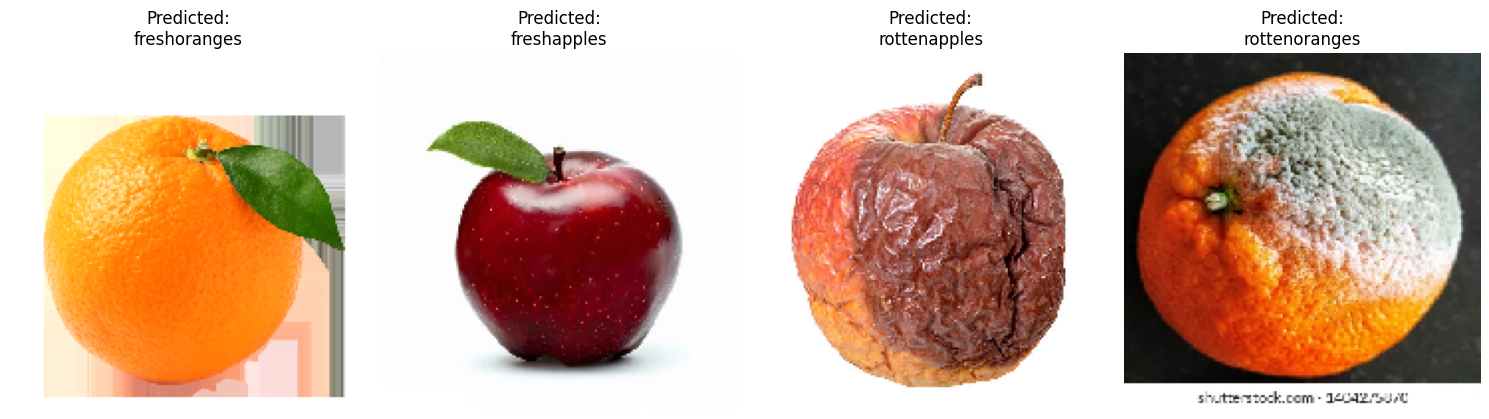

In [45]:
image_paths = [
    r"D:\Study stuff\Fruit insights project\model\Model-1-fruit-freshness\new images\fresh-orange-1000x1000.png",
    r"D:\Study stuff\Fruit insights project\model\Model-1-fruit-freshness\new images\fresh-red-apple-500x500.webp",
    r"D:\Study stuff\Fruit insights project\model\Model-1-fruit-freshness\new images\istockphoto-519974059-612x612.jpg",
    r"D:\Study stuff\Fruit insights project\model\Model-1-fruit-freshness\new images\orange-rotten-260nw-1404275870.webp"
]
plt.figure(figsize=(15, 5))

for i, img_path in enumerate(image_paths):

    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0 

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    plt.subplot(1, len(image_paths), i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted:\n{train_ds.class_names[predicted_class]}")

plt.tight_layout()
plt.show()


#### Side-by-Side Image Analysis using Test Dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


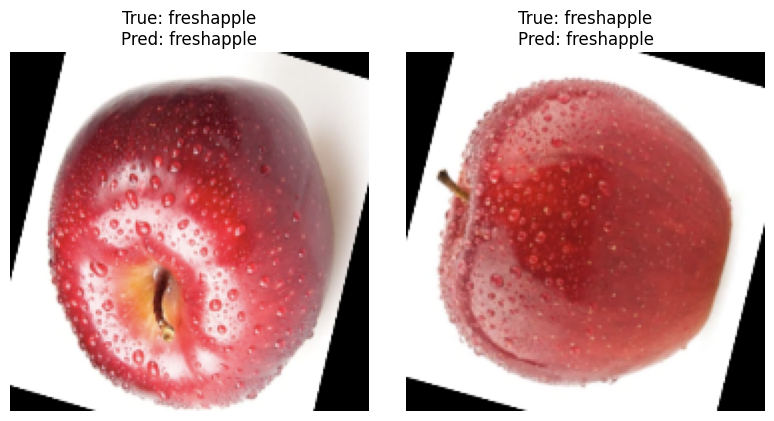

In [44]:
import matplotlib.pyplot as plt

shuffled_test_ds = test_ds.shuffle(buffer_size=1000)

for images, labels in shuffled_test_ds.take(1):
    preds = model.predict(images)
    pred_classes = preds.argmax(axis=1)
    true_classes = labels.numpy().argmax(axis=1)
    
    plt.figure(figsize=(16, 8))
    for i in range(min(2, len(images))): 
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i] ]}\nPred: {class_names[pred_classes[i]] }")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### Save model

In [31]:
model.save('fruit_freshness_cnn_model.keras')
